# GAN
0. [Import modules](#Import-modules)
1. [Load and prepare image dataset](#Load-&-prepare-image-dataset)
2. [Create models: generator & discriminator](#Create-models)
3. [Define loss & optimizers](#Discriminator-loss)
4. [Train & save models](#Train-&-save-models)
5. [Track progress on tensorboard](#Track-progress-on-tensorboard)
6. [Reload models & generate fake image](#Reload-models-&-generate-fake-image)

## Import modules

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Init Plugin
Num GPUs Available:  1
Init Graph Optimizer
Init Kernel


In [1]:
# import tensorflow as tf
import tensorflow.compat.v2 as tf

tf.enable_v2_behavior()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

Init Plugin
Init Graph Optimizer
Init Kernel


In [4]:
# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')
# tf.config.run_functions_eagerly(False)

In [2]:
# modules to handle files
from pathlib import Path
import os.path

# module to prepare data and train model
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# module to plot 
from matplotlib import pyplot as plt

In [3]:
import os
import glob
import time
from IPython import display

import PIL
import imageio

import numpy as np

## Load & prepare image dataset

In [4]:
# get dataset directory
# train_data_dir = Path("../assets/datasets/birds/birds_100x100")
train_data_dir = Path("../assets/datasets/kaggle_birds/birds_rev2/train")
train_data_dir

PosixPath('../assets/datasets/kaggle_birds/birds_rev2/train')

In [5]:
# CONSTANTS
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 9

In [6]:
def prep_fn(img):
    """
    Function to scale pixel values from the range of unsigned integers in [0,255]
    to the normalized range of [-1,1]
    
    Good practice for the real images to be scaled to the same range.

    Important as to have the same input shape and range in discriminator and in generator.
    Indeed, Generator model will generate images with pixel values in range [-1,1] as it will use
    the tanh activation function.
    """
    # convert from unsigned int to float
    img = img.astype(np.float32)
    
    # scale from [0,255] to [-1,1]
    img = (img - 127.5) / 127.5
    return img

# create image data augmentation generator
train_datagen = ImageDataGenerator(
    preprocessing_function=prep_fn
    # featurewise_center=True, # set input mean to 0 over the dataset, feature-wise
    # featurewise_std_normalization=True # divide inputs by std of the dataset, feature-wise
    # rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
                                  )
# create iterator
train_iterator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # resize to (height, width)
    batch_size= BATCH_SIZE,
    shuffle=True,
    # color_mode="grayscale",
    classes=["SCARLET IBIS","SHOEBILL","SORA"]
)

Found 513 images belonging to 3 classes.


In [7]:
# get total number of images
train_iterator.samples

513

In [8]:
# number of batches with a batch size of 9 samples
len(train_iterator)

57

In [9]:
# proof
train_iterator.samples/len(train_iterator)

9.0

In [10]:
128 * 32 * 32

131072

In [11]:
100 * 100 * 30

300000

### plot 1 generated batch of images

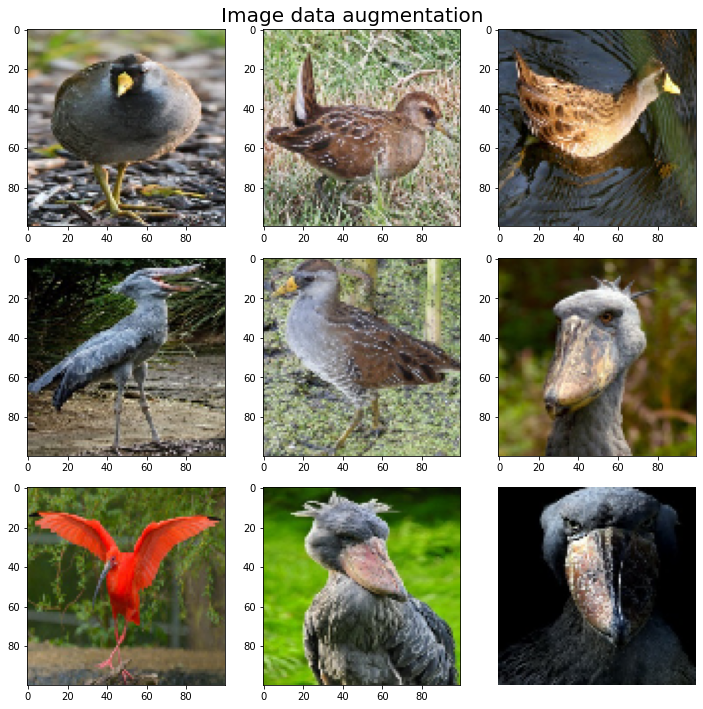

In [69]:
# set subplots grid
len_rows = 3
len_cols = 3
fig, ax = plt.subplots(BATCH_SIZE//len_rows,len_cols, figsize=(10,10))

# generate samples and plot
for i in range(BATCH_SIZE):
    
    # define subplot
    ax_i=ax[i//len_rows,i - len_cols*(i//len_cols)]
    
    # generate batch of images
    batch = train_iterator.next()
    
    # convert to unsigned integers for viewing
    # img = (batch[0][1]*255).astype('uint8')
    # img = batch[0][1].astype('uint8')
    # img = ((batch[0][1] + 127.5) * 127.5).astype('uint8')
    img = ((batch[0][1] + 1)/2) # scale from [-1,1] to [0,1]
    
    # turn off axis
    ax_i.axis("off")
    
    # plot raw pixel data
    # ax_i.imshow(img, cmap="gray")
    ax_i.imshow(img)
   

# show the figure
fig.suptitle('Image data augmentation', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## Create models

### Create generator

We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

Therefore, the first hidden layer, the Dense, needs enough nodes for multiple versions of our output image, such as 256.


Note: the generator model is not compiled and does not specify a loss function or optimization algorithm. This is because the generator is not trained directly. We will learn more about this in the next section.

In [13]:
def make_generator_model(noise_dim):
    """
    Function to create a generator model
    with Keras Sequential API.
    
    
    """
    # instantiate sequential model
    model = tf.keras.Sequential()
    
    # define dense layer
    model.add(tf.keras.layers.Dense(25*25*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    
    # LeakyReLU with a default slope of 0.2
    # reported as a best practice when training GAN models
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # reshape the activations from the nodes to sth image-like
    # to pass into a convolutional layer: 256 different 25x25 feature maps
    model.add(tf.keras.layers.Reshape((25,25,256)))
    assert model.output_shape == (None,25,25,256) # None is the batch size
    
    # upsampling the low-resolution image to a higher resolution version of the image
    # with Conv2DTranspose (combines 2 operations: UpSampling2D layer and a normal Conv2D layer)
    # UpSampling2D is like a reverse pooling layer
    # a stride of (2x2): will decuple the area of input feature maps (quintuple their width and height dimensions)
    # good practice to use a kernel size that is a factor of the stride 
    # to avoid a checkerboard pattern that can sometimes be observed when upsampling.
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(1,1), padding="same", use_bias=False))
    assert model.output_shape == (None,25,25,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # upsampling to 50x50
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None,50,50,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # upsampling to 100x100
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None,100,100,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # define output layer: 3 filters for the 3 required channels
    # and a kernel of size 3x3 'same' padding to create a single feature map
    # and preserve its dimensions at 100x100x3 pixels
    # tanh activation to ensure output values are in [-1,1], a current best practice
    # model.add(tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))
    # assert model.output_shape == (None, 100, 100, 3)
    
    model.add(tf.keras.layers.Conv2D(3, (3,3), activation="tanh", padding="same"))
    
    return model
    

### create an image with the initial generator (not yet trained)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160000)            16000000  
_________________________________________________________________
batch_normalization (BatchNo (None, 160000)            640000    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 160000)            0         
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 128)       524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 128)       512       
__________________________________________________

NotImplementedError: Cannot convert a symbolic Tensor (truediv:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

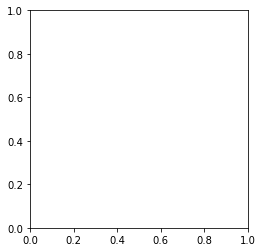

In [14]:
# define size of noise space
noise_dim = 100

# create generator instance
generator = make_generator_model(noise_dim)

# input noise into model to generate an image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# scale from [-1,1] to [0,1]
generated_image_0 = (generated_image[0] + 1) / 2

# summarize the model
generator.summary()

plt.imshow(generated_image_0)

In [15]:
tf.random.normal([1, 100])

<tf.Tensor 'random_normal_1:0' shape=(1, 100) dtype=float32>

As the model is not trained, the generated images are completely random pixel values in [-1, 1], rescaled to [0, 1]. As we might expect, the images look like a mess of gray.

### Create discriminator

In [16]:
def make_discriminator_model(input_shape=(100,100,3)):
    """
    Function to define the standalone discriminator model
    """
    model = tf.keras.Sequential()
    # normal convolutional layer
    model.add(tf.keras.layers.Conv2D(64, (5,5), padding="same", input_shape=input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Dropout(0.3))
    
    # downsample
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same", activation=LeakyReLU(alpha=0.2)))
    # model.add(tf.keras.layers.Dropout(0.3))
    
    # downsample
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(tf.keras.layers.Conv2D(256, (5,5), strides=(2,2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # classifier
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    # compile model
    # opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    # model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [17]:
# define model
discriminator = make_discriminator_model()
# summarize model
discriminator.summary()

# plot the model
# tf.keras.utils.plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 64)      4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       409728    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)      

In [18]:
# the number of parameters in first layer is
## 64 kernels of 3x3 pixels in the 3 channels + 64 bias terms
print("number of parameters in 1st layer: ", 64*5*5*3 + 64)

# the number of parameters in last layer (dense layer) is
## 43264 (the big 1D array) * 1 unit + 1 bias terms
print("number of parameters in last layer: ", 43264*1 + 1)

number of parameters in 1st layer:  4864
number of parameters in last layer:  43265


In [19]:
# calculate size of a layer output
I = 100 # Input size: 100x100 pixels
K = 5 # Kernel size: 5x5 pixels
P = 1 # zero padding size: padding of 1 pixel around the input image
S = 2 # strides of 2 pixels
((I - K + 2*P)/S) + 1

49.5

### classify an image with the initial discriminator (not yet trained):
binary classification:
- real: class label of 1
- fake: class label of 0

model outputs probability of image being real (or fake)

In [20]:
decision = discriminator(generated_image)
print(decision)

Tensor("sequential_1/dense_1/Sigmoid:0", shape=(1, 1), dtype=float32)


## Define loss and optimizers

In [21]:
# get helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [22]:
accuracy = tf.keras.metrics.BinaryAccuracy()

### Generator loss
quantifies how well generator fool discriminator. A good generator should make the discriminator classify fake images as real (1):
- compares discriminator's predictions on fake images to an array of 1s.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator loss
quantifies how well discriminator classify real and fake images:
- compares discriminator's predictions on real images to an array of 1s (as the discriminator outputs need to go close to 1)
- compares discriminator's predictions on fake images to an array of 0s (as the discriminator outputs need to go close to 0)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Optimizers
different discriminator and generator optimizers as we train the 2 networks separately.

the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum of 0.5, recommended when training deep convolutional GANs.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

## Train & save models

### Save checkpoints

In [26]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
                                )

In [27]:
def generate_and_save_images(model, epoch, test_input):
    # predict
    ## training = False to make all layers run in inference mode (batchnorm)
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
        
    plt.savefig(f"image_at_epoch_{epoch:04d}.png") # e.g. image_at_epoch_0001.png
    plt.show()

### Training loop
1. generator receives random seed as input
2. generator produce an image
3. discriminator classifies real images (from training set) and fake images (from generator)
4. calcul loss for each model
5. get gradients 
6. use gradients to update generator and discriminator with optimizer

In [28]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# seed to visualize progress in animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#### Functions

In [35]:
@tf.function # decorator to compile the function
def train_step(real_images, epoch):
    # create random seed
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # track gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # 1. 2. generate image from noise as input
        generated_images = generator(noise, training=True)
        
        # 3. classify real images & fake images
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # 4. compute generator loss & discriminator loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # 5. get gradients of generator & discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 6. use gradients to update generator & discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # accuracy.update_state(real_output, tf.ones_like(real_output))


In [30]:
image_batch = train_iterator.next()

# 1. 2. generate image from noise as input
generated_images = generator(noise, training=False)

# 3. classify real images & fake images
real_output = discriminator(image_batch[0], training=False)
fake_output = discriminator(generated_images, training=False)

# 4. compute generator loss & discriminator loss
gen_loss = generator_loss(fake_output)
disc_loss = discriminator_loss(real_output, fake_output)

gen_loss
disc_loss

<tf.Tensor 'add_1:0' shape=() dtype=float32>

In [38]:
# def train(dataset, epochs):
@tf.function # decorator to compile the function
def train(train_iterator, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        # remember reset states here，then GradientTape will get similar loss & acc with model.fit
        # train_loss.reset_states()
      #  accuracy.reset_states()
        
        #for image_batch in dataset:
       #     train_step(image_batch)
        # generate batch of images
        
        # loss and accuracy
       #  gen_loss_history = []
       # disc_loss_history = []
       # accuracy_history = []
        
      #  bar = tf.keras.utils.Progbar(train_iterator.samples, unit_name="sample", stateful_metrics={"loss", "acc"})
      #  log_values = []
        
        for i in range(9):
            image_batch = train_iterator.next()
            train_step(image_batch[0], epoch)
            
            # loss and accuracy
       #     gen_loss_history.append(gen_loss)
       #     disc_loss_history.append(disc_loss)
       #     accuracy_history.append(accuracy.result())

        # Read out training results
       # readout = f'Epoch {epoch + 1}, Training loss: {loss_values}, Training accuracy: {accuracy.result() * 100}'
       # print(readout)
        

   # for batch_x, batch_y in trainset:
   #     train_op(batch_x, batch_y)
      #  log_values.append(("loss", train_loss.result().numpy()))
      #  log_values.append(("acc", train_acc.result().numpy()))
      #  bar.add(len(batch_y), log_values)
            
        # produces images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # save model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        end_time = time.time()
        runtime_s = end_time - start_time
        print(f"time for epoch {epoch + 1}: {runtime_s} sec")
        
    # generate image after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

#### Train
>Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

>At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore not many batches will be required before it learns to discriminate perfectly.

In [39]:
# train(train_dataset, EPOCHS)
train(train_iterator, EPOCHS)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


TypeError: in user code:

    /var/folders/bc/pp_vy12j36gdx8lc7csstvqh0000gn/T/ipykernel_78708/2080228350.py:43 train  *
        display.clear_output(wait=True)
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/display.py:1471 clear_output  *
        InteractiveShell.instance().display_pub.clear_output(wait)
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py:155 clear_output  *
        self.session.send(
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/site-packages/jupyter_client/session.py:742 send  *
        to_send = self.serialize(msg, ident)
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/site-packages/jupyter_client/session.py:640 serialize  *
        real_message = [self.pack(msg['header']),
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/site-packages/jupyter_client/session.py:82 None  *
        )
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/site-packages/zmq/utils/jsonapi.py:41 dumps  *
        s = jsonmod.dumps(o, **kwargs)
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/json/__init__.py:238 dumps  *
        **kw).encode(obj)
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/json/encoder.py:199 encode  *
        chunks = self.iterencode(o, _one_shot=True)
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/json/encoder.py:257 iterencode  *
        return _iterencode(o, 0)
    /Users/derrickvanfrausum/anaconda3/envs/mlp/lib/python3.8/site-packages/jupyter_client/jsonutil.py:90 date_default  **
        raise TypeError("%r is not JSON serializable" % obj)

    TypeError: <tensorflow.python.autograph.core.function_wrappers.FunctionScope object at 0x2e94e36a0> is not JSON serializable


 https://colab.research.google.com/gist/NLP-ZY/3762cb58f789d36511f812edabe129aa/untitled0.ipynb

In [ ]:
@tf.function
def train_op(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_object(y, y_pred)
        scaled_loss = optimizer.get_scaled_loss(loss)
    scaled_grads = tape.gradient(scaled_loss, model.trainable_weights)
    grads = optimizer.get_unscaled_gradients(scaled_grads)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_loss.update_state(loss)
    train_acc.update_state(y, y_pred)


@tf.function
def val_op(x, y):
    y_pred = model(x)
    loss = loss_object(y, y_pred)
    val_loss.update_state(loss)
    val_acc.update_state(y, y_pred)


for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch + 1, epochs))
    # remember reset states here，then GradientTape will get similar loss & acc with model.fit
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()
    bar = tfk.utils.Progbar(len(y_train), unit_name="sample", stateful_metrics={"loss", "acc"})
    log_values = []
    for batch_x, batch_y in trainset:
        train_op(batch_x, batch_y)
        log_values.append(("loss", train_loss.result().numpy()))
        log_values.append(("acc", train_acc.result().numpy()))
        bar.add(len(batch_y), log_values)
    for batch_x, batch_y in valset:
        val_op(batch_x, batch_y)
    template = "val_loss: {:.4f} - val_acc: {:.4f}"
    print(template.format(val_loss.result().numpy(), val_acc.result().numpy()))



## Track progress on tensorboard

## Reload models & generate fake image

In [141]:
# Restore the latest checkpoint
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint("/Users/derrickvanfrausum/Downloads"))

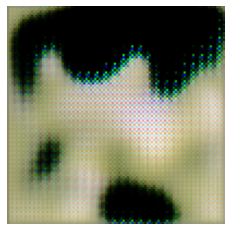

In [210]:
# input noise into model to generate an image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image_0 = (generated_image[0] + 1) / 2
plt.imshow(generated_image_0)
plt.axis("off")
plt.show()

## Create GIF

In [142]:
# Display a single image using the epoch number
def display_image(epoch_no):
  # return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
  return PIL.Image.open(f'/content/image_at_epoch_{epoch_no:04d}.png')

In [144]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: '/content/image_at_epoch_0001.png'

Use imageio to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan-birds-dataA-epochs401-900.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
%%time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

tf.enable_v2_behavior()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

batch_size = 128

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu'),
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                 activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#   tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

model.fit(
    ds_train,
    epochs=12,
    validation_data=ds_test,
)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function normalize_img at 0x105b1f550>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-07-14 09:30:06.191838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-14 09:30:06.192039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function normalize_img at 0x105b1f550>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function normalize_img at 0x105b1f550>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-07-14 09:30:06.233629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-14 09:30:06.233654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-07-14 09:30:06.239369: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-07-14 09:30:06.324748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-07-14 09:30:06.334437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-07-14 09:30:06.376898: I tensorflow/core/grappler/o

Train on 469 steps, validate on 79 steps
Epoch 1/12


In [60]:
# calculate output size of a convolutional layer
# e.g. input shape (100,100,64) into Conv2D(128, (5,5), strides=(2,2), padding="same")

#=> output shape should be (50,50,128) # with 128 as the number of filters

input_shape: tuple = (100,100,64)
output_shape: list = []

# convolution layer parameters:
nb_filters = 128 # number of filters (= nodes)
kernel = 5 # Kernel size: 5
padding = "same" # padding: padding of zeros around the input image
# if "same", add `pad` padding such that output image has the same dimensions as input image
if padding == "same":
    pad = (kernel - 1)/2 # padding size
# if "valid" (by default), no padding
elif padding == "valid":
    pad = 0
stride = 2 # strides of 2 pixels

# iterate over the 1st 2 dimensions (the last dimension is added after the loop)
# here: 1st dimension = 100 pixels
for input_dimension in input_shape[:-1]:

  # formula to calculate output size of a convolutional layer
  output_size = int(((input_dimension - kernel + 2*pad)/stride) + 1)

  # append output size to output_shape
  output_shape.append(output_size)

# append number of filters to output_shape
output_shape.append(nb_filters)

output_shape = tuple(output_shape)
output_shape

(50, 50, 128)

In [68]:
checkpoint_dir: .PosixPath

NameError: name 'PosixPath' is not defined